In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import mlflow

In [2]:
# Cargar el archivo Excel (ajusta la ruta del archivo)
ruta_archivo = "Online Retail.xlsx"
df = pd.read_excel(ruta_archivo, engine="openpyxl")

# Mostrar las primeras filas para verificar que se cargó correctamente
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [96]:
df_sin_duplicados = df.drop_duplicates(subset='StockCode')

# Seleccionar únicamente la columna 'Producto'
columna_producto =df_sin_duplicados[df_sin_duplicados['Description'] != ""]

columna_producto = columna_producto['Description'] 

# Guardar la columna en un archivo CSV
columna_producto.to_csv('products.csv', index=False, header=True)

In [3]:
print(df.columns)  # Lista de columnas en el archivo

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [4]:
# Verificar y limpiar columnas
df.columns = df.columns.str.strip()  # Eliminar espacios en los nombres de las columnas
print("Columnas disponibles:", df.columns)

Columnas disponibles: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [5]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Month"] = df["InvoiceDate"].dt.month
df["Year"] = df["InvoiceDate"].dt.year
df["StockCode"] = df["StockCode"].astype(str)  # Convertir a string
df = df.dropna(subset=["StockCode"])  # Eliminar valores nulos en StockCode

In [6]:
le = LabelEncoder()
df["StockCode"] = le.fit_transform(df["StockCode"])

In [21]:
print(df["StockCode"].head)

<bound method NDFrame.head of 0         3536
1         2794
2         3044
3         2985
4         2984
          ... 
541904    1527
541905    1803
541906    2145
541907    2146
541908    1093
Name: StockCode, Length: 541909, dtype: int64>


In [7]:
X = df[["Month", "Year", "StockCode"]]  # Ahora StockCode es numérico
y = df["Quantity"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
# defina el servidor para llevar el registro de modelos y artefactos
mlflow.set_tracking_uri('http://localhost:8050')
randomForest = mlflow.set_experiment("RandomForestRegressor")

2025/03/07 19:33:48 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestRegressor' does not exist. Creating a new experiment.


In [139]:
# Entrenar modelo
with mlflow.start_run(experiment_id=randomForest.experiment_id, nested=True) as run:
    n_estimators = 100 
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("mae", mean_absolute_error(y_test, model.predict(X_test)))
    mlflow.log_metric("mse", mean_squared_error(y_test, model.predict(X_test)))
    # Registre los parámetros
    mlflow.log_param("num_trees", n_estimators)
    # Registre el modelo
    mlflow.sklearn.log_model(model, "random-forest-model")

2025/03/07 20:15:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run beautiful-sheep-361 at: http://localhost:8050/#/experiments/895459103735821031/runs/4377adeb186a43ac86766c7f0ff305ad
🧪 View experiment at: http://localhost:8050/#/experiments/895459103735821031


In [140]:
linearRegression = mlflow.set_experiment("LinearRegressionx")
with mlflow.start_run(experiment_id=linearRegression.experiment_id, nested=True) as run:
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    mlflow.log_metric("mae", mean_absolute_error(y_test, model_lr.predict(X_test)))
    mlflow.log_metric("mse", mean_squared_error(y_test, model.predict(X_test)))
        
    mlflow.sklearn.log_model(model, "linear-regresion-model")

    #y_pred = model_lr.predict(X_test)
    #mae_reg = mean_absolute_error(y_test, y_pred)

#print(f"MAE con Regresión Lineal: {mae_reg}")

2025/03/07 20:15:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run awesome-loon-274 at: http://localhost:8050/#/experiments/533296179510911120/runs/dbdc107a761742d19df0892ec808da04
🧪 View experiment at: http://localhost:8050/#/experiments/533296179510911120


In [98]:
import joblib
# Guardar modelo entrenado
joblib.dump(model_lr, 'demand_model.pkl')
# Guardar LabelEncoder en un archivo .pkl
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

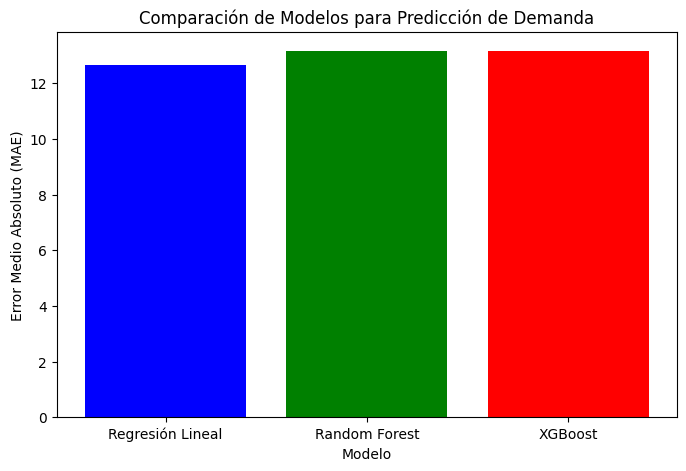

In [14]:
import matplotlib.pyplot as plt

modelos = ["Regresión Lineal", "Random Forest", "XGBoost"]
mae_scores = [mae_reg, mae_rf, mae_xgb]

plt.figure(figsize=(8,5))
plt.bar(modelos, mae_scores, color=["blue", "green", "red", "purple", "orange"])
plt.xlabel("Modelo")
plt.ylabel("Error Medio Absoluto (MAE)")
plt.title("Comparación de Modelos para Predicción de Demanda")
plt.show()

In [86]:
# Definir los valores de entrada (producto, año y mes)
producto = "100000"  # Código del producto a predecir
año = 2025
mes = 12

# Crear DataFrame con los datos de entrada
X_nuevo = pd.DataFrame({"Month": [mes], "Year": [año], "StockCode": [producto]})

# Hacer la predicción
prediccion = model_lr.predict(X_nuevo)

print(f"Predicción de demanda para el producto {producto} en {mes}/{año}: {prediccion[0]:.2f} unidades")

Predicción de demanda para el producto 100000 en 12/2025: 22.89 unidades
